In [2]:
import warnings
import numpy as np
import _pickle as cp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics

import torch
from torch import nn
import torch.nn.functional as F

import os
import sys

import numpy as np
from numpy.lib.stride_tricks import as_strided as ast
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt  
import scikitplot as skplt 

In [3]:
torch.manual_seed(0)

In [4]:
def norm_shape(shape):
    '''
    Normalize numpy array shapes so they're always expressed as a tuple,
    even for one-dimensional shapes.
    Parameters
        shape - an int, or a tuple of ints
    Returns
        a shape tuple
    '''
    try:
        i = int(shape)
        return (i,)
    except TypeError:
        # shape was not a number
        pass

    try:
        t = tuple(shape)
        return t
    except TypeError:
        # shape was not iterable
        pass

    raise TypeError('shape must be an int, or a tuple of ints')

def sliding_window(a,ws,ss = None,flatten = True):
    '''
    Return a sliding window over a in any number of dimensions
    Parameters:
        a  - an n-dimensional numpy array
        ws - an int (a is 1D) or tuple (a is 2D or greater) representing the size
             of each dimension of the window
        ss - an int (a is 1D) or tuple (a is 2D or greater) representing the
             amount to slide the window in each dimension. If not specified, it
             defaults to ws.
        flatten - if True, all slices are flattened, otherwise, there is an
                  extra dimension for each dimension of the input.
    Returns
        an array containing each n-dimensional window from a
    '''

    if None is ss:
        # ss was not provided. the windows will not overlap in any direction.
        ss = ws
    ws = norm_shape(ws)
    ss = norm_shape(ss)

    # convert ws, ss, and a.shape to numpy arrays so that we can do math in every
    # dimension at once.
    ws = np.array(ws)
    ss = np.array(ss)
    shape = np.array(a.shape)


    # ensure that ws, ss, and a.shape all have the same number of dimensions
    ls = [len(shape),len(ws),len(ss)]
    if 1 != len(set(ls)):
        raise ValueError(\
        'a.shape, ws and ss must all have the same length. They were %s' % str(ls))

    # ensure that ws is smaller than a in every dimension
    if np.any(ws > shape):
        raise ValueError(\
        'ws cannot be larger than a in any dimension.\
 a.shape was %s and ws was %s' % (str(a.shape),str(ws)))

    # how many slices will there be in each dimension?
    newshape = norm_shape(((shape - ws) // ss) + 1)
    # the shape of the strided array will be the number of slices in each dimension
    # plus the shape of the window (tuple addition)
    newshape += norm_shape(ws)
    # the strides tuple will be the array's strides multiplied by step size, plus
    # the array's strides (tuple addition)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides
    strided = ast(a,shape = newshape,strides = newstrides)
    if not flatten:
        return strided

    # Collapse strided so that it has one more dimension than the window.  I.e.,
    # the new array is a flat list of slices.
    meat = len(ws) if ws.shape else 0
    firstdim = (np.product(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    # remove any dimensions with size 1
    dim = tuple(filter(lambda i : i != 1,dim))
    return strided.reshape(dim)

In [16]:
data_df = pd.read_csv("ubicomp08_routines_lda_5_topic_5_doc_nan_no_overlap_doc_topic_chunk_2_unlabeled_filtered_labels.csv")

In [17]:
data_df.replace(np.nan, -1, inplace=True)

In [18]:
data_df.topic.unique()

array([ 0.,  4.,  3.,  2.,  1., -1.])

In [19]:
data_df.astype({'topic': 'int32'}).dtypes

mean_poc_x         float64
mean_poc_y         float64
mean_poc_z         float64
var_poc_x          float64
var_poc_y          float64
var_poc_z          float64
mean_wri_x         float64
mean_wri_y         float64
mean_wri_z         float64
var_wri_x          float64
var_wri_y          float64
var_wri_z          float64
timestamp           object
simple_activity      int64
activity             int64
day                  int64
hour                 int64
word                 int64
docs               float64
topic                int32
dtype: object

In [20]:
class HARModel(nn.Module):
    
    def __init__(self, n_hidden=128, n_layers=1, n_filters=64, 
                 n_classes=5, filter_size=5, drop_prob=0.5):
        super(HARModel, self).__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_filters = n_filters
        self.n_classes = n_classes
        self.filter_size = filter_size
             
        self.conv1 = nn.Conv1d(NB_SENSOR_CHANNELS, n_filters, filter_size)
        self.conv2 = nn.Conv1d(n_filters, n_filters, filter_size)
        self.conv3 = nn.Conv1d(n_filters, n_filters, filter_size)
        self.conv4 = nn.Conv1d(n_filters, n_filters, filter_size)
        
        self.lstm1  = nn.LSTM(n_filters, n_hidden, n_layers)
        self.lstm2  = nn.LSTM(n_hidden, n_hidden, n_layers)
        
        self.fc = nn.Linear(n_hidden, n_classes)

        self.dropout = nn.Dropout(drop_prob)
    
    def forward(self, x, hidden, batch_size):
        
        x = x.reshape(-1, NB_SENSOR_CHANNELS, SLIDING_WINDOW_LENGTH)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        x = x.reshape(8, -1, self.n_filters)
        x, hidden = self.lstm1(x, hidden)
        x, hidden = self.lstm2(x, hidden)
        
        x = x.contiguous().view(-1, self.n_hidden)
        x = self.dropout(x)
        x = self.fc(x)
        
        out = x.view(batch_size, -1, self.n_classes)[:,-1,:]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [21]:
def init_weights(m):
    if type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    elif type(m) == nn.Conv1d or type(m) == nn.Linear:
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0)

In [22]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [23]:
def train(net, epochs=50, batch_size=128, lr=0.001):
    
    opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    if(train_on_gpu):
        net.cuda()
     
    for e in range(epochs):
        
        # initialize hidden state
        h = net.init_hidden(batch_size)         
        train_losses = []    
        net.train()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            x, y = batch

            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

            if(train_on_gpu):
                    inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])
            
            # zero accumulated gradients
            opt.zero_grad()   
            #print(inputs.shape)
            # get the output from the model
            output, h = net(inputs, h, batch_size)
            
            loss = criterion(output, targets.long())
            train_losses.append(loss.item())
            loss.backward()
            opt.step()
        print("Epoch:{}".format(e+1))
    net.eval()       
    val_h = net.init_hidden(X_test.shape[0])
    val_losses = []
    accuracy = []
    f1score = []

    inputs, targets = torch.from_numpy(X_test), torch.from_numpy(y_test)
    val_h = tuple([each.data for each in val_h])
    output, val_h= net(inputs, val_h, X_test.shape[0])

    val_loss = criterion(output, targets.long())
    val_losses.append(val_loss.item())

    #print(output.shape)
    pred_numpy = torch.argmax(output, dim = 1).detach().cpu().numpy()
    target_numpy = targets.detach().cpu().numpy()
    
    conf_mat = confusion_matrix(target_numpy, pred_numpy)
    conf_mat = (conf_mat.T/conf_mat.astype(np.float).sum(axis=1)).T
    print(conf_mat)
    skplt.metrics.plot_confusion_matrix(target_numpy, pred_numpy, normalize=True)
    print(classification_report(target_numpy, pred_numpy))
    accuracy = accuracy_score(target_numpy, pred_numpy)
    f1score_micro = f1_score(target_numpy, pred_numpy, average='micro')
    f1score_macro = f1_score(target_numpy, pred_numpy, average='macro')
    f1score_weighted = f1_score(target_numpy, pred_numpy, average='weighted')
                
    print("Val Acc: {:.4f}...".format(accuracy),
    "Micro F1-Score: {:.4f}...".format(f1score_micro),
    "Macro F1-Score: {:.4f}...".format(f1score_macro),
    "Weighted F1-Score: {:.4f}...".format(f1score_weighted))
    
    return (conf_mat, f1score_micro, f1score_macro, f1score_weighted)

In [24]:
test_days_list = [3, 1, 7, 2, 6, 5, 4]

In [25]:
NB_SENSOR_CHANNELS = 14
SLIDING_WINDOW_LENGTH = 24
SLIDING_WINDOW_STEP = 12

 ..after sliding and reshaping, train data: inputs (36302, 24, 14), targets (36302,)
 ..after sliding and reshaping, test data : inputs (6572, 24, 14), targets (6572,)
Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8
Epoch:9
Epoch:10
Epoch:11
Epoch:12
Epoch:13
Epoch:14
Epoch:15
Epoch:16
Epoch:17
Epoch:18
Epoch:19
Epoch:20
Epoch:21
Epoch:22
Epoch:23
Epoch:24
Epoch:25
Epoch:26
Epoch:27
Epoch:28
Epoch:29
Epoch:30
Epoch:31
Epoch:32
Epoch:33
Epoch:34
Epoch:35
Epoch:36
Epoch:37
Epoch:38
Epoch:39
Epoch:40
Epoch:41
Epoch:42
Epoch:43
Epoch:44
Epoch:45
Epoch:46
Epoch:47
Epoch:48
Epoch:49
Epoch:50
[[0.96035242 0.02422907 0.         0.0154185 ]
 [0.00307692 0.90153846 0.00923077 0.08615385]
 [0.         0.03764115 0.27227102 0.69008783]
 [0.0030024  0.00580464 0.01000801 0.98118495]]
              precision    recall  f1-score   support

           1       0.96      0.96      0.96       454
           2       0.81      0.90      0.85       325
           3       0.80      0.27      

Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8
Epoch:9
Epoch:10
Epoch:11
Epoch:12
Epoch:13
Epoch:14
Epoch:15
Epoch:16
Epoch:17
Epoch:18
Epoch:19
Epoch:20
Epoch:21
Epoch:22
Epoch:23
Epoch:24
Epoch:25
Epoch:26
Epoch:27
Epoch:28
Epoch:29
Epoch:30
Epoch:31
Epoch:32
Epoch:33
Epoch:34
Epoch:35
Epoch:36
Epoch:37
Epoch:38
Epoch:39
Epoch:40
Epoch:41
Epoch:42
Epoch:43
Epoch:44
Epoch:45
Epoch:46
Epoch:47
Epoch:48
Epoch:49
Epoch:50
[[0.34897361 0.35190616 0.00293255 0.29618768]
 [0.00323625 0.7184466  0.17152104 0.10679612]
 [0.         0.01904762 0.44761905 0.53333333]
 [0.00201658 0.04145194 0.03495407 0.92157741]]
              precision    recall  f1-score   support

           1       0.92      0.35      0.51       341
           2       0.41      0.72      0.52       309
           3       0.53      0.45      0.48       525
           4       0.91      0.92      0.92      4463

    accuracy                           0.83      5638
   macro avg       0.69      0.61      0.61 

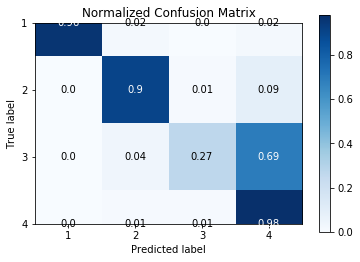

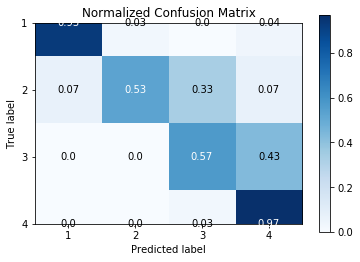

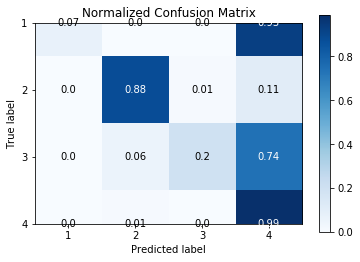

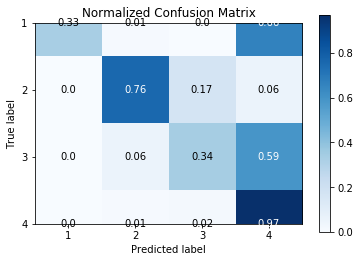

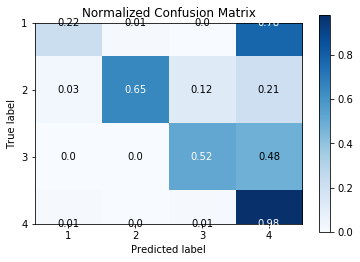

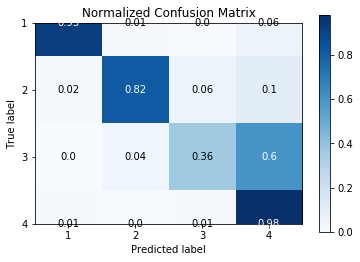

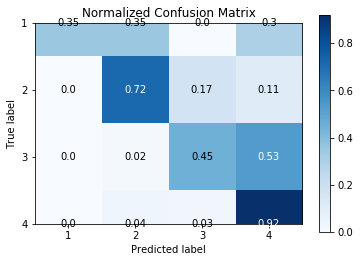

In [26]:
conf_mats, micro_f1_scores, macro_f1_scores, weighted_f1_scores = [], [], [], []
for fold_idx in range(7):
    x_train, y_simple_train, y_complex_train, x_test, y_simple_test, y_complex_test = [], [], [], [], [], []

    test_df = data_df[data_df.day == test_days_list[fold_idx]]

    train_df = data_df[data_df.day != test_days_list[fold_idx]]

    X_train = train_df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16]].values
    y_train = train_df.iloc[:, 14].values
    X_test = test_df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 16]].values
    y_test = test_df.iloc[:, 14].values

    assert NB_SENSOR_CHANNELS == X_train.shape[1]
    def opp_sliding_window(data_x, data_y, ws, ss):
        data_x = sliding_window(data_x, (ws, data_x.shape[1]), (ss, 1))
        data_y = np.asarray([[i[-1]] for i in sliding_window(data_y, ws, ss)])
        return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

    # Sensor data is segmented using a sliding window mechanism
    X_train, y_train = opp_sliding_window(X_train, y_train, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
    X_test, y_test = opp_sliding_window(X_test, y_test, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)

    # Data is reshaped
    X_train = X_train.reshape((-1, SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)) # for input to Conv1D
    X_test = X_test.reshape((-1, SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS)) # for input to Conv1D

    print(" ..after sliding and reshaping, train data: inputs {0}, targets {1}".format(X_train.shape, y_train.shape))
    print(" ..after sliding and reshaping, test data : inputs {0}, targets {1}".format(X_test.shape, y_test.shape))

    net = HARModel()

    net.apply(init_weights)

    train_on_gpu = False

    conf_mat, fold_f1_micro, fold_f1_macro, fold_f1_weighted = train(net, 50, 256)
    conf_mats.append(conf_mat)
    micro_f1_scores.append(fold_f1_micro)
    macro_f1_scores.append(fold_f1_macro)
    weighted_f1_scores.append(fold_f1_weighted)
print("Confusion Matrix:{}".format(np.mean(conf_mats, axis = 0)*100))
print("Overall F1 Micro:{}, F1 Macro:{}, F1 Weighted:{}".format(np.mean(micro_f1_scores), np.mean(macro_f1_scores), np.mean(weighted_f1_scores)))
print("Std-dev F1 Micro:{}, F1 Macro:{}, F1 Weighted:{}".format(np.std(micro_f1_scores), np.std(macro_f1_scores), np.std(weighted_f1_scores)))
print("Micro:", micro_f1_scores)
print("Macro:", macro_f1_scores)
print("Weighted:", weighted_f1_scores)

In [ ]:
#Topic - filter unlabeled


Confusion Matrix:[[5.39633288e+01 6.20227642e+00 7.39963190e-02 3.97603984e+01]
 [1.83768751e+00 7.50853010e+01 1.25194205e+01 1.05575910e+01]
 [0.00000000e+00 3.21792340e+00 3.87520383e+01 5.80300383e+01]
 [3.50366259e-01 9.67978920e-01 1.55348183e+00 9.71281730e+01]]
Overall F1 Micro:0.8829062888352102, F1 Macro:0.6868101176882809, F1 Weighted:0.8684892540795517
Std-dev F1 Micro:0.02331705916798616, F1 Macro:0.08429823260442693, F1 Weighted:0.022795136790715514
Micro: [0.8898356664637858, 0.8960353922069083, 0.8870682730923695, 0.8707136997538967, 0.8988501916347275, 0.906162898730257, 0.8316778999645266]
Macro: [0.7890482371613818, 0.7430054803506524, 0.562392780816102, 0.6516310294290475, 0.6564792260394248, 0.7974244596616394, 0.607689610359719]
Weighted: [0.8688920897800092, 0.8931977160787293, 0.8530314642018467, 0.8539688563677007, 0.8882202734206716, 0.8932836376857293, 0.828830741022175]

In [ ]:
#Baseline - filter unlabeled

Confusion Matrix:[[4.74735611e+01 2.58490127e+00 3.21027287e-02 4.99094349e+01]
 [2.93716538e+00 6.48460280e+01 1.51116376e+01 1.71051690e+01]
 [0.00000000e+00 3.64477300e+00 3.59799315e+01 6.03752955e+01]
 [5.10140776e-01 9.12621930e-01 1.56346571e+00 9.70137716e+01]]
Overall F1 Micro:0.868974103735406, F1 Macro:0.642223241724624, F1 Weighted:0.8498124590800817
Std-dev F1 Micro:0.010018569925280432, F1 Macro:0.07672783886618827, F1 Weighted:0.015165076356951135
Micro: [0.8695982958003652, 0.8609834949804321, 0.8605622489959839, 0.8564397046759639, 0.887352107982003, 0.8773614122019202, 0.8705214615111742]
Macro: [0.7222381732768196, 0.5556464072678526, 0.5104295023324605, 0.6554802764364243, 0.6330775838597782, 0.7276817875460883, 0.6910089613529438]
Weighted: [0.8479268487668318, 0.8305559683848917, 0.8297070038273834, 0.845640107991571, 0.8729925840520104, 0.8647552305898025, 0.8571094699480827]

In [ ]:
#Baseline - filter unlabeled

Confusion Matrix:[[5.54585754e+01 2.65387708e+00 3.21027287e-02 4.18554448e+01]
 [4.22468933e+00 6.39881284e+01 1.51467204e+01 1.66404618e+01]
 [2.72108844e-02 2.21072458e+00 3.94681464e+01 5.82939181e+01]
 [1.62355287e+00 1.21214274e+00 1.13376554e+00 9.60305388e+01]]
Overall F1 Micro:0.8651705672955441, F1 Macro:0.6578944883087778, F1 Weighted:0.8504736278286791



In [ ]:
#with topic - filter unlabeled

Confusion Matrix:[[6.32055500e+01 2.26501451e+00 0.00000000e+00 3.45294354e+01]
 [4.28054478e+00 6.73439977e+01 1.30237954e+01 1.53516622e+01]
 [1.79243592e-02 2.58051885e+00 3.54331277e+01 6.19684291e+01]
 [3.78055541e-01 5.20744422e-01 1.29770882e+00 9.78034912e+01]]
Overall F1 Micro:0.8842016702081661, F1 Macro:0.6944268863687812, F1 Weighted:0.8676467249075606


In [ ]:
def train(net, epochs=10, batch_size=128, lr=0.001):
    
    opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    if(train_on_gpu):
        net.cuda()
     
    for e in range(epochs):
        
        # initialize hidden state
        h = net.init_hidden(batch_size)         
        train_losses = []    
        net.train()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            x, y = batch

            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

            if(train_on_gpu):
                    inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])
            
            # zero accumulated gradients
            opt.zero_grad()   
            #print(inputs.shape)
            # get the output from the model
            output, h = net(inputs, h, batch_size)
            
            loss = criterion(output, targets.long())
            train_losses.append(loss.item())
            loss.backward()
            opt.step()
        print("Epoch:{}".format(e+1))
    net.eval()       
    val_h = net.init_hidden(X_test.shape[0])
    val_losses = []
    accuracy = []
    f1score = []

    inputs, targets = torch.from_numpy(X_test), torch.from_numpy(y_test)
    val_h = tuple([each.data for each in val_h])
    output, val_h= net(inputs, val_h, X_test.shape[0])

    val_loss = criterion(output, targets.long())
    val_losses.append(val_loss.item())

    #print(output.shape)
    pred_numpy = torch.argmax(output, dim = 1).detach().cpu().numpy()
    target_numpy = targets.detach().cpu().numpy()
    
    print(confusion_matrix(target_numpy, pred_numpy))
    print(classification_report(target_numpy, pred_numpy))
    accuracy = accuracy_score(target_numpy, pred_numpy)
    f1score = f1_score(target_numpy, pred_numpy, average='macro')
    
            
    '''for batch in iterate_minibatches(X_test, y_test, batch_size):
        x, y = batch     

        inputs, targets = torch.from_numpy(x), torch.from_numpy(y)-1

        val_h = tuple([each.data for each in val_h])

        if(train_on_gpu):
            inputs, targets = inputs.cuda(), targets.cuda()

        output, val_h= net(inputs, val_h, batch_size)

        val_loss = criterion(output, targets.long())
        val_losses.append(val_loss.item())

        #print(output.shape)

        accuracy.append(accuracy_score(torch.argmax(output, dim = 1).detach().cpu().numpy(), targets.detach().cpu().numpy()))
        f1score.append(f1_score(torch.argmax(output, dim = 1).detach().cpu().numpy(), targets.detach().cpu().numpy(), average='macro'))
    '''    
    #top_p, top_class = output.topk(1, dim=1)
    #equals = top_class == targets.view(*top_class.shape).long()
    #accuracy += torch.mean(equals.type(torch.FloatTensor))
    #f1score += metrics.f1_score(top_class.cpu(), targets.view(*top_class.shape).long().cpu(), average='weighted')

                
    print("Val Acc: {:.4f}...".format(accuracy),
    "F1-Score: {:.4f}...".format(f1score))